# Optiver Realized Volatility Prediction - EDA

This notebook seeks to conduct exploratory data analysis for the challenge. This includes devloping helper functions for data reading, manipulating and modelling. This is a forecasting challenge, and the dataset contains stock market data relevant to the practical execution of trades in the financial markets. In particular, it includes order book snapshots and executed trades. With one second resolution, it provides a uniquely fine grained look at the micro-structure of modern financial markets.

## Files
**book_[train/test].parquet** - A [parquet](https://arrow.apache.org/docs/python/parquet.html) file partitioned by `stock_id`. Provides order book data on the most competitive buy and sell orders entered into the market. The top two levels of the book are shared. The first level of the book will be more competitive in price terms, it will then receive execution priority over the second level.

 - `stock_id` - ID code for the stock. Not all `stock_id`s exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
 - `time_id` - ID code for the time bucket. `time_id`s are not necessarily sequential but are consistent across all stocks.
 - `seconds_in_bucket` - Number of seconds from the start of the bucket, always starting from 0.
 - `bid_price[1/2]` - Normalized prices of the most/second most competitive buy level.
 - `ask_price[1/2]` - Normalized prices of the most/second most competitive sell level.
 - `bid_size[1/2]` - The number of shares on the most/second most competitive buy level.
 - `ask_size[1/2]` - The number of shares on the most/second most competitive sell level.
 
**trade_[train/test].parquet** - A [parquet](https://arrow.apache.org/docs/python/parquet.html) file partitioned by `stock_id`. Contains data on trades that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades, therefore one may expect this file to be more sparse than the order book.

 - `stock_id` - Same as above.
 - `time_id` - Same as above.
 - `seconds_in_bucket` - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
 - `price` - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
 - `size` - The sum number of shares traded.
 - `order_count` - The number of unique trade orders taking place.
 
**train.csv** The ground truth values for the training set.

 - `stock_id` - Same as above, but since this is a csv the column will load as an integer instead of categorical.
 - `time_id` - Same as above.
 - `target` - The realized volatility computed over the 10 minute window following the feature data under the same `stock_id`/`time_id`. There is no overlap between feature and target data. 
 
**test.csv** Provides the mapping between the other data files and the submission file. As with other test files, most of the data is only available to your notebook upon submission with just the first few rows available for download.

 - `stock_id` - Same as above.
 - `time_id` - Same as above.
 - `row_id` - Unique identifier for the submission row. There is one row for each existing `stock_id`/`time_id` pair. Each time window is not necessarily containing every individual stock.
 
**sample_submission.csv** - A sample submission file in the correct format.

 - `row_id` - Same as in test.csv.
 - `target` - Same definition as in **train.csv**. The benchmark is using the median target value from **train.csv**.
 
## 1.00 Prepare Environment
### 1.01 Import Packages

In [1]:
# Data manipulation packages
import pandas as pd
import numpy as np
import pyarrow.parquet as pq # To handle parquet files
from datetime import datetime as dt

# General packages
import multiprocessing
import os
from pathlib import Path
import gc
import random
from tqdm import tqdm, tqdm_notebook
import time
import warnings

# Data vis packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Package options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = [14, 8]
np.random.seed(14)

In [2]:
# Get number of cpu cores for multiprocessing
try:
    cpus = int(multiprocessing.cpu_count() / 2)
except NotImplementedError:
    cpus = 1 # Default number of cores

### 1.02 Read in Data

In [3]:
# Data paths
comp_dir_path = Path("../input/optiver-realized-volatility-prediction")

# Train paths
train_book_path   = comp_dir_path/"book_train.parquet"
train_trade_path  = comp_dir_path/"trade_train.parquet"
train_labels_path = comp_dir_path/"train.csv"

# Test paths
test_book_path   = comp_dir_path/"book_test.parquet"
test_trade_path  = comp_dir_path/"trade_test.parquet"
test_labels_path = comp_dir_path/"test.csv"

# Sample submission path
sample_sub_path = comp_dir_path/"sample_submission.csv"

In [4]:
def get_stock_ids_list(data_dir_path):
    data_dir = os.listdir(data_dir_path)
    # Get list of stock ids in directory
    stock_ids = list(map(lambda x: x.split("=")[1], data_dir))
    return stock_ids
    
    
def load_book_stock_id_data(stock_id):
    # Get stock id extension
    stock_id_ext = f"stock_id={stock_id}"
    
    # Read individual stock parquet file
    if is_train_test == "train":
        book_stock_id_path = os.path.join(train_book_path, stock_id_ext)
    elif is_train_test == "test":
        book_stock_id_path = os.path.join(test_book_path, stock_id_ext)
    book_stock_id = pd.read_parquet(book_stock_id_path)
    
    # Add stock id feature from filename
    book_stock_id["stock_id"] = stock_id
            
    return book_stock_id

def load_trade_stock_id_data(stock_id):
    # Get stock id extension
    stock_id_ext = f"stock_id={stock_id}"
    
    # Read individual stock parquet file
    if is_train_test == "train":
        trade_stock_id_path = os.path.join(train_trade_path, stock_id_ext)
    elif is_train_test == "test":
        trade_stock_id_path = os.path.join(test_trade_path, stock_id_ext)
    trade_stock_id = pd.read_parquet(trade_stock_id_path)
    
    # Add stock id feature from filename
    trade_stock_id["stock_id"] = stock_id
            
    return trade_stock_id

In [5]:
%%time
# Get list of stock ids
train_stock_ids = get_stock_ids_list(train_book_path)
test_stock_ids = get_stock_ids_list(test_book_path)

# Read train data
is_train_test = "train"
# Create worker pool and read
pool         = multiprocessing.Pool(processes=cpus)
train_book   = pd.concat(pool.map(load_book_stock_id_data, train_stock_ids[0:2]))
train_trade  = pd.concat(pool.map(load_trade_stock_id_data, train_stock_ids[0:2]))
train_labels = pd.read_csv(train_labels_path)
# Close worker pool
pool.close()
pool.join()

# Read test data
is_train_test = "test"
# Create worker pool and read
pool        = multiprocessing.Pool(processes=cpus)
test_book   = pd.concat(pool.map(load_book_stock_id_data, test_stock_ids))
test_trade  = pd.concat(pool.map(load_trade_stock_id_data, test_stock_ids))
test_labels = pd.read_csv(test_labels_path)

# Read sample submission
sample_sub = pd.read_csv(sample_sub_path)

# Print data dimensions
print("TRAIN DATA DIMENSIONS")
print(f"train_book shape: {train_book.shape}")
print(f"train_trade shape: {train_trade.shape}")
print(f"train_labels shape: {train_labels.shape}")

print("\nTEST DATA DIMENSIONS")
print(f"test_book shape: {test_book.shape}")
print(f"test_trade shape: {test_trade.shape}")
print(f"test_labels shape: {test_labels.shape}\n")

TRAIN DATA DIMENSIONS
train_book shape: (2425085, 11)
train_trade shape: (419653, 6)
train_labels shape: (428932, 3)

TEST DATA DIMENSIONS
test_book shape: (3, 11)
test_trade shape: (3, 6)
test_labels shape: (3, 3)

CPU times: user 216 ms, sys: 511 ms, total: 727 ms
Wall time: 1.06 s


## 2.00 Label and Submission Data
The submission consists of a `row_id` (a `stock_id`-`time_id` pair), and its corresponding target value (the realized volatility for that particular stock ID and 10 minute time window).

In [6]:
sample_sub.head()

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


In [7]:
train_labels.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [8]:
test_labels.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [9]:
print(f"{len(train_labels['stock_id'].unique())} \tStock IDs in training data")
print(f"{len(train_labels['time_id'].unique())} \tTime IDs in training data")
print(f"{train_labels.shape[0]} \tStock/Time ID pairs in training data")
print(f"\n{train_labels.groupby('stock_id')['time_id'].count().mean()} mean Time IDs per Stock ID")

112 	Stock IDs in training data
3830 	Time IDs in training data
428932 	Stock/Time ID pairs in training data

3829.75 mean Time IDs per Stock ID


In [10]:
print("Train - Realized Volatility Descriptives")
print("--------------------------------------")
print(train_labels["target"].describe())

Train - Realized Volatility Descriptives
--------------------------------------
count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64


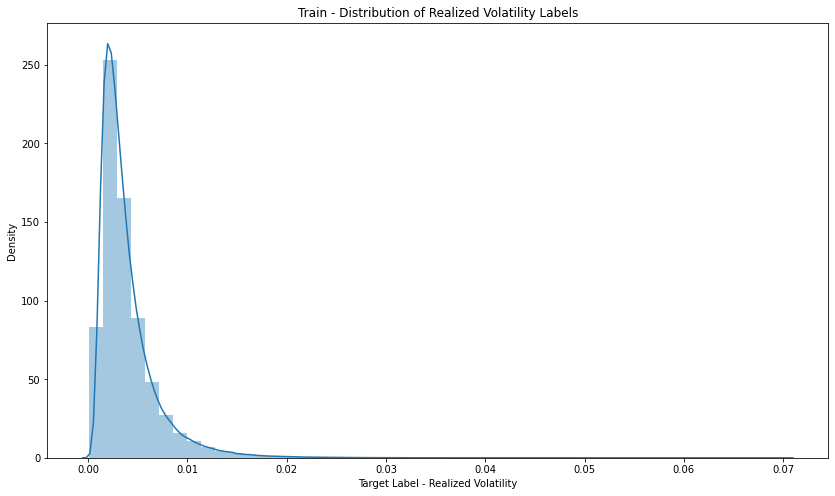

In [11]:
sns.distplot(train_labels["target"])
plt.xlabel("Target Label - Realized Volatility")
plt.title("Train - Distribution of Realized Volatility Labels")
plt.show()

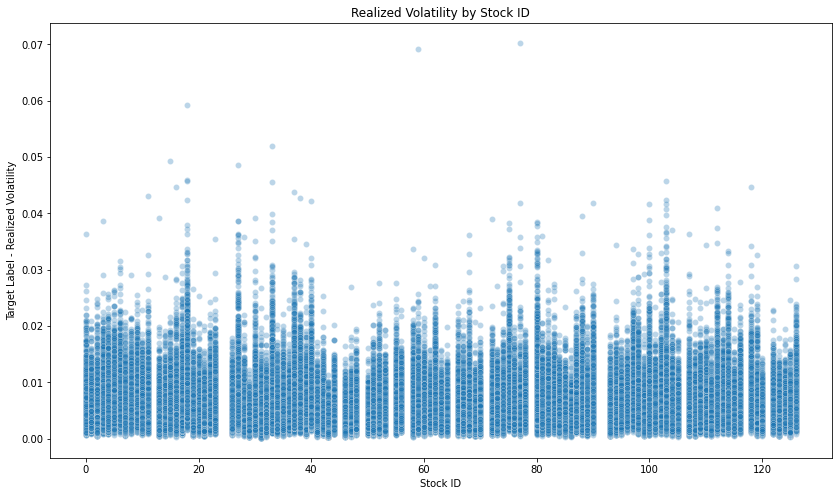

In [12]:
sns.scatterplot(x=train_labels["stock_id"], y=train_labels["target"], alpha=0.3)
plt.xlabel("Stock ID")
plt.ylabel("Target Label - Realized Volatility")
plt.title("Realized Volatility by Stock ID")
plt.show()

## 3.00 Order Book Data
The term order book refers to an electronic list of buy and sell orders for a specific security or financial instrument organized by price level. An order book lists the number of shares being bid on or offered at each price point.

Below is a snapshot of an order book of a stock (let's call it stock A), as you can see, all intended buy orders are on the left side of the book displayed as "bid" while all intended sell orders are on the right side of the book displayed as "offer/ask"

![Order book example](../input/img/orderbook_example.png)


An actively traded financial instrument always has a dense order book (A liquid book). As the order book data is a continous representation of market demand/supply it is always considered as the number one data source for market research.



In [13]:
train_book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


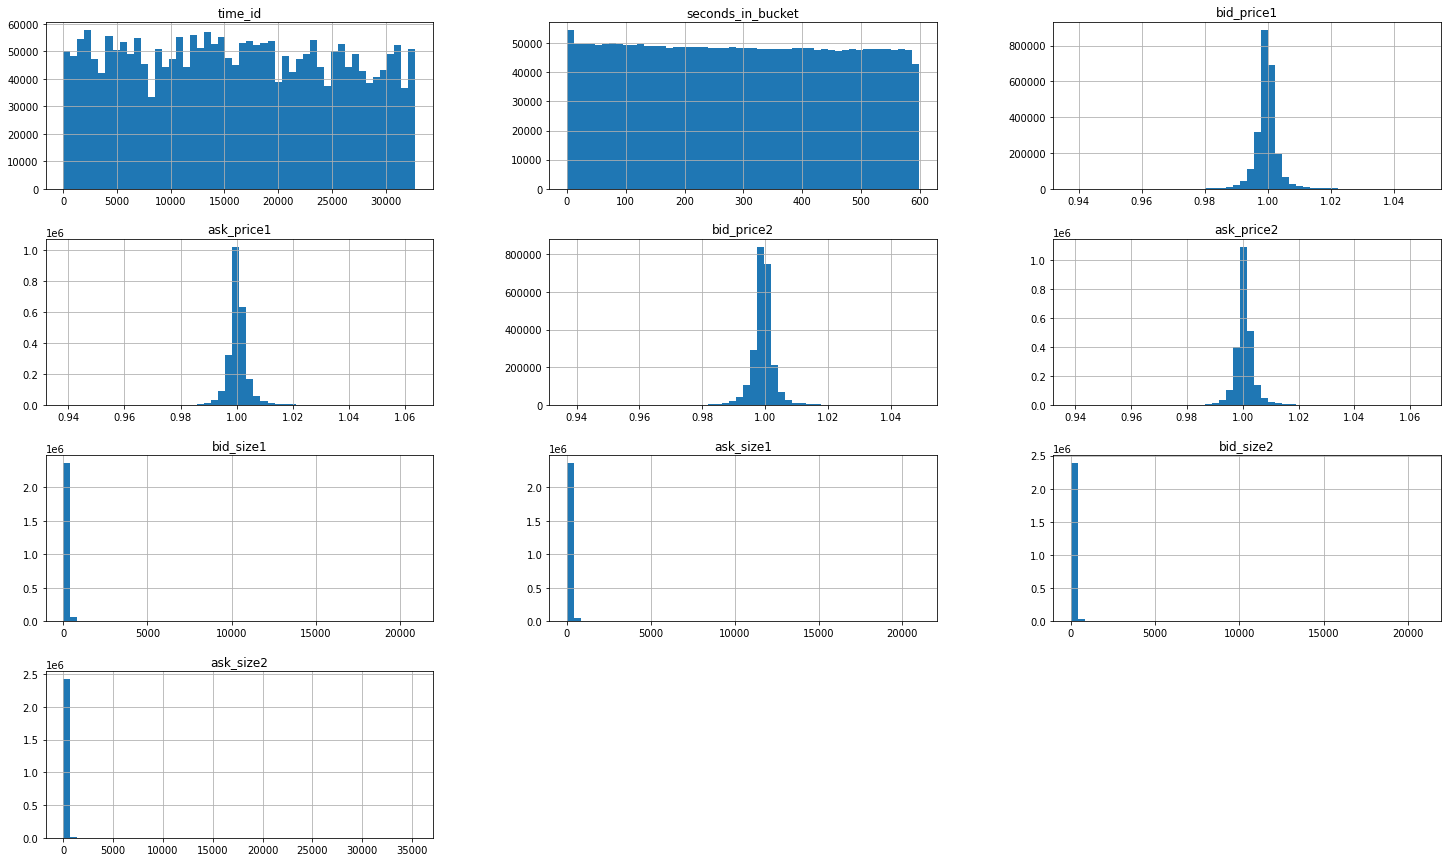

In [14]:
# Plot histograms for numeric features
train_book.hist(bins=50, figsize=(25,15))
plt.show()

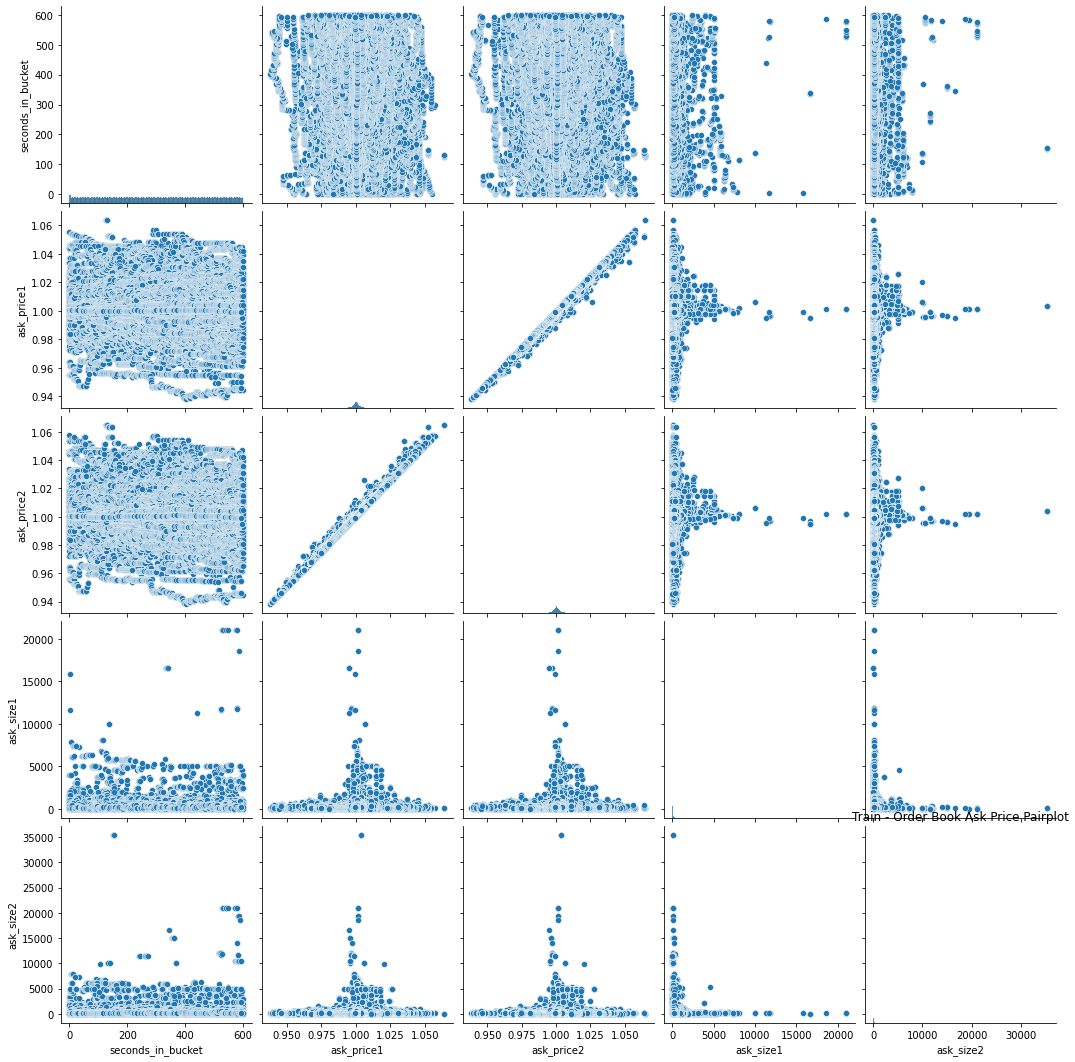

In [15]:
# Plot pairplot looking at ask price features
sns.pairplot(
    train_book[["seconds_in_bucket", "ask_price1", "ask_price2", "ask_size1", "ask_size2"]],  
    diag_kind="hist", 
    height=3
)
plt.title("Train - Order Book Ask Price Pairplot")
plt.show()

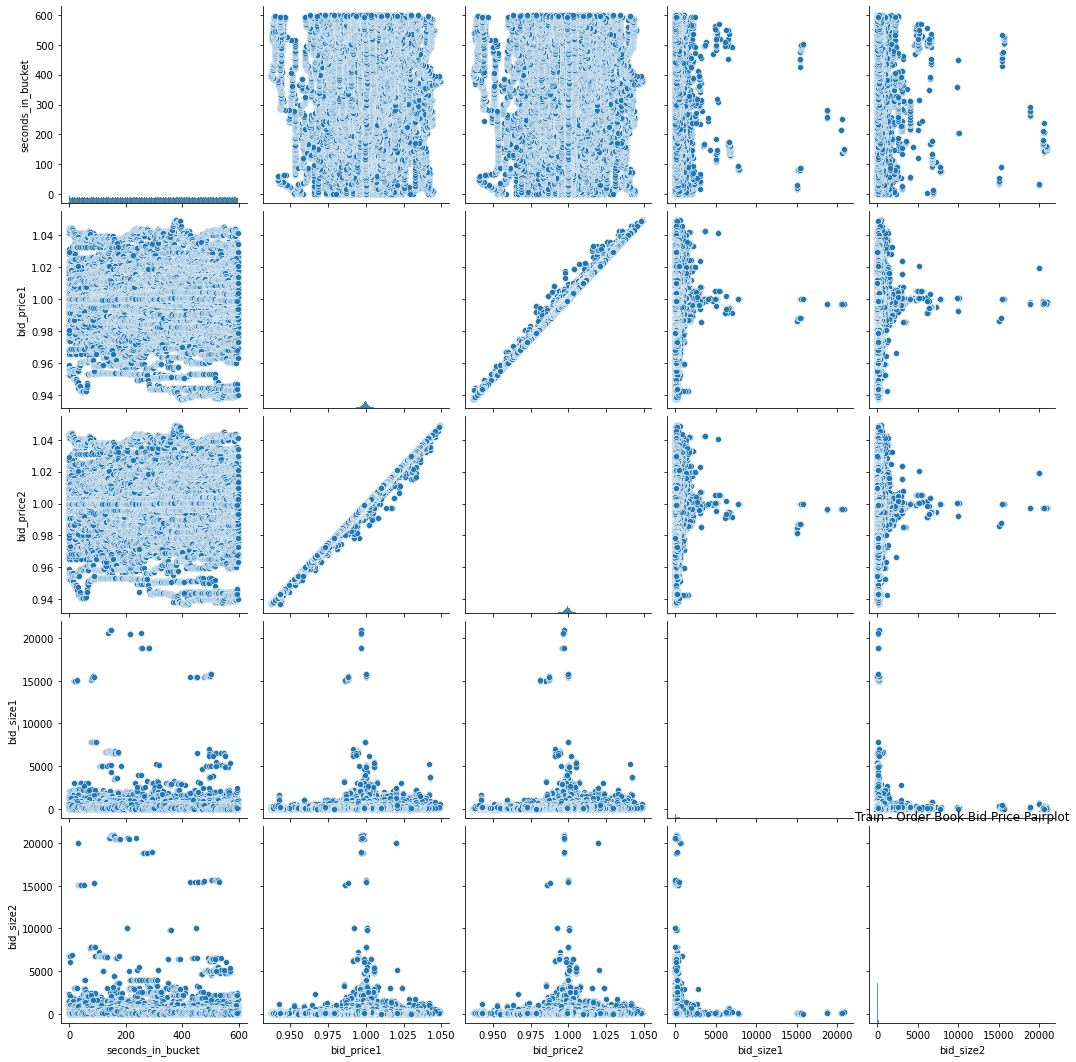

In [16]:
# Plot pairplot looking at bid price features
sns.pairplot(
    train_book[["seconds_in_bucket", "bid_price1", "bid_price2", "bid_size1", "bid_size2"]], 
    diag_kind="hist", 
    height=3
)
plt.title("Train - Order Book Bid Price Pairplot")
plt.show()

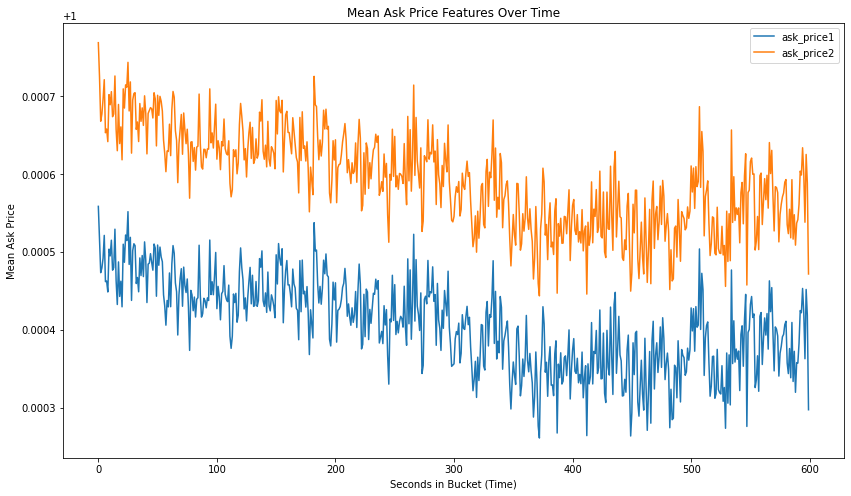

In [22]:
# Plot mean ask price features across stocks over time (by seconds in bucket)
sns.lineplot(x="seconds_in_bucket", y="ask_price1", data=train_book, ci=None)
sns.lineplot(x="seconds_in_bucket", y="ask_price2", data=train_book, ci=None)
plt.legend(labels=["ask_price1", "ask_price2"])
plt.xlabel("Seconds in Bucket (Time)")
plt.ylabel("Mean Ask Price")
plt.title("Mean Ask Price Features Over Time")
plt.show()

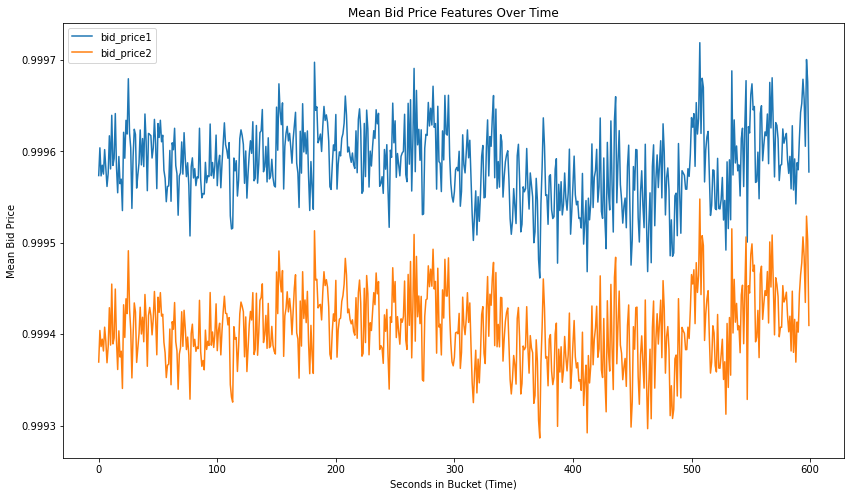

In [23]:
# Plot mean bid price features over time (by seconds in bucket)
sns.lineplot(x="seconds_in_bucket", y="bid_price1", data=train_book, ci=None)
sns.lineplot(x="seconds_in_bucket", y="bid_price2", data=train_book, ci=None)
plt.legend(labels=["bid_price1", "bid_price2"])
plt.xlabel("Seconds in Bucket (Time)")
plt.ylabel("Mean Bid Price")
plt.title("Mean Bid Price Features Over Time")
plt.show()

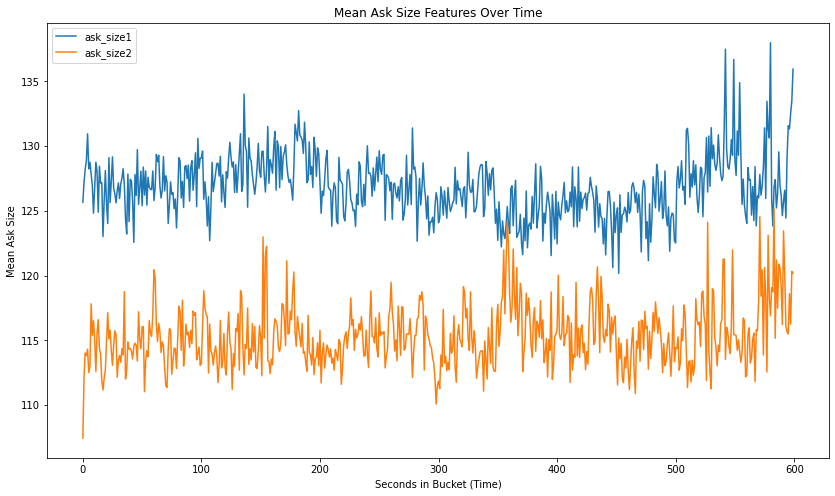

In [24]:
# Plot mean ask size features over time (by seconds in bucket)
sns.lineplot(x="seconds_in_bucket", y="ask_size1", data=train_book, ci=None)
sns.lineplot(x="seconds_in_bucket", y="ask_size2", data=train_book, ci=None)
plt.legend(labels=["ask_size1", "ask_size2"])
plt.xlabel("Seconds in Bucket (Time)")
plt.ylabel("Mean Ask Size")
plt.title("Mean Ask Size Features Over Time")
plt.show()

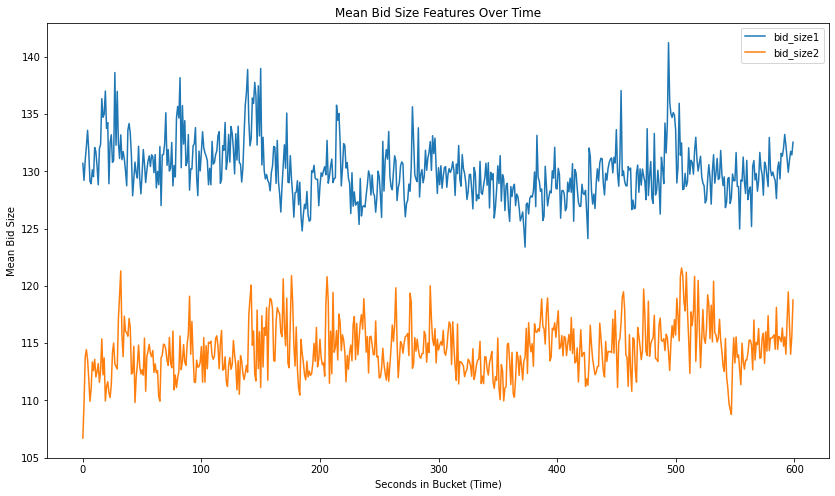

In [25]:
# Plot mean bid size features over time (by seconds in bucket)
sns.lineplot(x="seconds_in_bucket", y="bid_size1", data=train_book, ci=None)
sns.lineplot(x="seconds_in_bucket", y="bid_size2", data=train_book, ci=None)
plt.legend(labels=["bid_size1", "bid_size2"])
plt.xlabel("Seconds in Bucket (Time)")
plt.ylabel("Mean Bid Size")
plt.title("Mean Bid Size Features Over Time")
plt.show()

## 4.00 Trade Data

An order book is a representation of trading intention on the market, however the market needs a buyer and seller at the **same** price to make the trade happen. Therefore, sometimes when someone wants to do a trade in a stock, they check the order book and find someone with counter-interest to trade with.

For example, imagine you want to buy 20 shares of a stock A when you have the order book in the previous paragraph. Then you need to find some people who are willing to trade against you by selling 20 shares or more in total. You check the **offer** side of the book starting from the lowest price: there are 221 shares of selling interest on the level of 148. You can **lift** 20 shares for a price of 148 and **guarantee** your execution. This will be the resulting order book of stock A after your trade:

![Trade book example](../input/img/trade_book_example.png)

In [1]:
train_trade.head()

NameError: name 'train_trade' is not defined

In [ ]:
# Plot histograms for numeric features
train_trade.hist(bins=50, figsize=(25,15))
plt.show()

In [ ]:
# Plot pairplot looking at trade numerical features
sns.pairplot(
    train_trade[["seconds_in_bucket", "price", "size"]], 
    diag_kind="hist", 
    height=3
)
plt.title("Train - Trade Pairplot")
plt.show()